In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
ratings = pd.read_csv("datasets/ml-latest/ratings.csv", usecols=['movieId', 'rating'])

In [4]:
genome_scores = pd.read_csv("datasets/ml-latest/genome-scores.csv")

In [5]:
genome_tags = pd.read_csv("datasets/ml-latest/genome-tags.csv")

In [6]:
movie_names = pd.read_csv("datasets/ml-latest/movies.csv")

In [7]:
links = pd.read_csv("datasets/ml-latest/links.csv")

In [8]:
movie_tags_in_text = pd.merge(genome_scores, genome_tags, on='tagId')[['movieId', 'tag', 'relevance']]

### Determine a good tag relevancy score cut-off

In [9]:
%matplotlib inline

In [10]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02400
1,1,2,0.02400
2,1,3,0.05475
3,1,4,0.09200
4,1,5,0.14825


In [11]:
genome_scores[:100000].pivot(index='movieId', columns='tagId')['relevance'].head()

tagId,1,2,3,4,5,6,7,8,9,10,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02400,0.02400,0.05475,0.09200,0.14825,0.21500,0.06625,0.27025,0.26050,0.03025,...,0.03650,0.01800,0.04525,0.03275,0.12450,0.04175,0.02000,0.03475,0.08350,0.02525
2,0.03800,0.04175,0.03700,0.04875,0.11075,0.07325,0.04950,0.10775,0.10200,0.02050,...,0.03900,0.01925,0.01725,0.02425,0.13425,0.02225,0.01600,0.01450,0.09600,0.02025
3,0.04200,0.05250,0.02725,0.07975,0.05625,0.07025,0.05975,0.18275,0.05175,0.02725,...,0.03950,0.02625,0.02725,0.03450,0.16925,0.03525,0.01725,0.01875,0.09925,0.02000
4,0.03600,0.03850,0.03500,0.03125,0.07100,0.04500,0.02475,0.08300,0.05150,0.02975,...,0.05375,0.03300,0.02275,0.04025,0.19600,0.05700,0.01550,0.01475,0.06625,0.01400
5,0.04075,0.05125,0.05800,0.03675,0.07575,0.12675,0.02975,0.08175,0.03075,0.02950,...,0.04000,0.02850,0.02100,0.02650,0.15475,0.02050,0.01700,0.01575,0.11275,0.01975


In [12]:
table = genome_scores[:100000].pivot_table('relevance', index='movieId', columns='tagId', aggfunc='mean')

In [13]:
table.head()

tagId,1,2,3,4,5,6,7,8,9,10,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02400,0.02400,0.05475,0.09200,0.14825,0.21500,0.06625,0.27025,0.26050,0.03025,...,0.03650,0.01800,0.04525,0.03275,0.12450,0.04175,0.02000,0.03475,0.08350,0.02525
2,0.03800,0.04175,0.03700,0.04875,0.11075,0.07325,0.04950,0.10775,0.10200,0.02050,...,0.03900,0.01925,0.01725,0.02425,0.13425,0.02225,0.01600,0.01450,0.09600,0.02025
3,0.04200,0.05250,0.02725,0.07975,0.05625,0.07025,0.05975,0.18275,0.05175,0.02725,...,0.03950,0.02625,0.02725,0.03450,0.16925,0.03525,0.01725,0.01875,0.09925,0.02000
4,0.03600,0.03850,0.03500,0.03125,0.07100,0.04500,0.02475,0.08300,0.05150,0.02975,...,0.05375,0.03300,0.02275,0.04025,0.19600,0.05700,0.01550,0.01475,0.06625,0.01400
5,0.04075,0.05125,0.05800,0.03675,0.07575,0.12675,0.02975,0.08175,0.03075,0.02950,...,0.04000,0.02850,0.02100,0.02650,0.15475,0.02050,0.01700,0.01575,0.11275,0.01975


In [14]:
%matplotlib inline

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1065d7550>]], dtype=object)

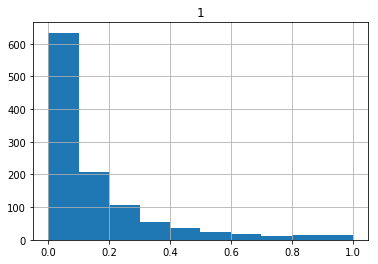

In [15]:
table[:1].T.hist()

conclusion: 0.3 seems to be a good cut-off

In [16]:
movie_tags = genome_scores[genome_scores.relevance > 0.3][['movieId', 'tagId']]

### Merge in tag and movie names

In [17]:
tags_to_movies = pd.merge(movie_tags, genome_tags, on='tagId', how='left')[['movieId', 'tagId']]

In [18]:
tags_to_movies['tagId'] = tags_to_movies.tagId.astype(str)

In [19]:
def _concatenate_tags_of_movie(tags):
    tags_as_str = ' '.join(set(tags))
    return tags_as_str

In [20]:
tags_per_movie = tags_to_movies.groupby('movieId')['tagId'].agg({
    'movie_tags': _concatenate_tags_of_movie
}).reset_index()

In [21]:
avg_ratings = ratings.groupby('movieId')['rating'].agg({
    'rating_mean': 'mean',
    'rating_median': 'median',
    'num_ratings': 'size'
}).reset_index()

In [22]:
movies_with_ratings = pd.merge(movie_names, avg_ratings, how='left', on='movieId')

In [23]:
dataset = pd.merge(movies_with_ratings, tags_per_movie, how='left', on='movieId')

In [24]:
dataset.rename(columns={'median': 'rating_median', 'mean': 'rating_mean', 'tagId': 'movie_tags'}, inplace=True)

### Extracting movie year from title

In [25]:
import re

def extract_year_from_movie_title(movie_title):
    matches = re.findall(r'\d{4}', movie_title)
    if len(matches) > 1:
        return int(matches[-1])
    if len(matches) < 1:
        return np.nan
    return int(matches[0])

In [26]:
dataset['year'] = dataset.title.apply(extract_year_from_movie_title)

In [27]:
dataset.head()

,movieId,title,genres,num_ratings,rating_median,rating_mean,movie_tags,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,63469.0,4.0,3.889300,113 93 1071 745 881 186 1025 464 588 355 942 1...,1995.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,25045.0,3.0,3.229527,113 745 881 186 694 20 464 588 355 314 22 664 ...,1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,15381.0,3.0,3.178142,1071 374 846 902 919 629 469 609 464 807 1057 ...,1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2961.0,3.0,2.879433,864 374 846 425 602 900 388 807 464 107 726 97...,1995.0
4,5,Father of the Bride Part II (1995),Comedy,15023.0,3.0,3.080410,1040 157 926 1071 204 864 374 334 902 694 919 ...,1995.0


There are movies without tags

In [28]:
dataset[dataset.movie_tags.isnull()].head()

,movieId,title,genres,num_ratings,rating_median,rating_mean,movie_tags,year
50,51,Guardian Angel (1994),Action|Drama|Thriller,34.0,3.00,2.588235,NaN,1994.0
107,109,Headless Body in Topless Bar (1995),Comedy|Drama|Thriller,18.0,2.25,2.333333,NaN,1995.0
113,115,Happiness Is in the Field (Bonheur est dans le...,Comedy,50.0,4.00,3.380000,NaN,1995.0
122,124,"Star Maker, The (Uomo delle stelle, L') (1995)",Drama,335.0,4.00,3.489552,NaN,1995.0
125,127,"Silences of the Palace, The (Saimt el Qusur) (...",Drama,51.0,3.00,3.215686,NaN,1994.0


There are movies without ratings

In [29]:
dataset[dataset.rating_mean.isnull()].head()

,movieId,title,genres,num_ratings,rating_median,rating_mean,movie_tags,year
8531,25981,Man on a Tightrope (1953),Drama,NaN,NaN,NaN,NaN,1953.0
9322,27396,"Gentleman's Game, A (2002)",Drama,NaN,NaN,NaN,NaN,2002.0
9779,31797,White Banners (1938),Drama,NaN,NaN,NaN,NaN,1938.0
13307,65078,Jane Austen in Manhattan (1980),Drama|Romance,NaN,NaN,NaN,NaN,1980.0
13510,66622,His Private Secretary (1933),Comedy|Romance,NaN,NaN,NaN,NaN,1933.0


Conclusion: These cannot be related to other movies due to lack of features (tags), they could be presented as a "random recommendation" solution

### Bag of words vectorization

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [31]:
from sklearn.metrics.pairwise import cosine_similarity

In [32]:
dataset_with_tags = dataset[~dataset.movie_tags.isnull()].reset_index(drop=True)

In [33]:
bag_of_words = CountVectorizer()

In [34]:
tags_as_descriptors = [' '.join(genome_tags.tagId.astype(str))]

In [35]:
movies_described_bag_of_words = bag_of_words.fit_transform(dataset_with_tags.movie_tags)

In [36]:
df_bag_m2m = pd.DataFrame(cosine_similarity(movies_described_bag_of_words))

### Tf-Idf Vectorization

In [37]:
tf_idf = TfidfVectorizer()

In [38]:
movies_tf_idf_described = tf_idf.fit_transform(dataset_with_tags.movie_tags)

In [39]:
m2m = cosine_similarity(movies_tf_idf_described)

In [40]:
df_tfidf_m2m = pd.DataFrame(cosine_similarity(movies_tf_idf_described))

In [41]:
df_tfidf_m2m.head()

,0,1,2,3,4,5,6,7,8,9,...,10664,10665,10666,10667,10668,10669,10670,10671,10672,10673
0,1.000000,0.431993,0.159781,0.141310,0.216984,0.256402,0.219518,0.255039,0.084687,0.251235,...,0.253995,0.245707,0.298894,0.218980,0.243204,0.228843,0.338929,0.390264,0.527402,0.210074
1,0.431993,1.000000,0.107847,0.120763,0.237059,0.120485,0.181958,0.282949,0.188213,0.234384,...,0.365564,0.130227,0.221158,0.171833,0.172612,0.160411,0.251052,0.265634,0.299784,0.181168
2,0.159781,0.107847,1.000000,0.260063,0.430876,0.118901,0.369714,0.206708,0.067116,0.175896,...,0.151341,0.135469,0.134628,0.093538,0.102329,0.123552,0.142192,0.124184,0.133702,0.096047
3,0.141310,0.120763,0.260063,1.000000,0.263465,0.088910,0.374638,0.244020,0.077906,0.075830,...,0.144143,0.136691,0.119444,0.108307,0.110534,0.113956,0.159768,0.165774,0.165368,0.079979
4,0.216984,0.237059,0.430876,0.263465,1.000000,0.050463,0.446251,0.182284,0.108008,0.137105,...,0.180975,0.204900,0.114578,0.107630,0.137742,0.105655,0.173343,0.187519,0.182170,0.098338


### Match indices to movie IDs

In [42]:
index_to_movie_id = dataset_with_tags['movieId']

In [43]:
index_to_movie_id[0]

1

In [44]:
index_to_movie_id[10665]

160980

In [45]:
dataset_with_tags.reset_index(drop=True).ix[50]

movieId                                                         52
title                                      Mighty Aphrodite (1995)
genres                                        Comedy|Drama|Romance
num_ratings                                                  10277
rating_median                                                    4
rating_mean                                                3.53741
movie_tags       829 335 1071 745 845 297 704 609 464 726 1062 ...
year                                                          1995
Name: 50, dtype: object

In [46]:
df_tfidf_m2m.columns = [str(index_to_movie_id[int(col)]) for col in df_tfidf_m2m.columns]

In [47]:
df_tfidf_m2m.index = [index_to_movie_id[idx] for idx in df_tfidf_m2m.index]

In [48]:
df_tfidf_m2m.head()

,1,2,3,4,5,6,7,8,9,10,...,160954,160980,161131,161354,161582,161634,162350,162376,162578,162600
1,1.000000,0.431993,0.159781,0.141310,0.216984,0.256402,0.219518,0.255039,0.084687,0.251235,...,0.253995,0.245707,0.298894,0.218980,0.243204,0.228843,0.338929,0.390264,0.527402,0.210074
2,0.431993,1.000000,0.107847,0.120763,0.237059,0.120485,0.181958,0.282949,0.188213,0.234384,...,0.365564,0.130227,0.221158,0.171833,0.172612,0.160411,0.251052,0.265634,0.299784,0.181168
3,0.159781,0.107847,1.000000,0.260063,0.430876,0.118901,0.369714,0.206708,0.067116,0.175896,...,0.151341,0.135469,0.134628,0.093538,0.102329,0.123552,0.142192,0.124184,0.133702,0.096047
4,0.141310,0.120763,0.260063,1.000000,0.263465,0.088910,0.374638,0.244020,0.077906,0.075830,...,0.144143,0.136691,0.119444,0.108307,0.110534,0.113956,0.159768,0.165774,0.165368,0.079979
5,0.216984,0.237059,0.430876,0.263465,1.000000,0.050463,0.446251,0.182284,0.108008,0.137105,...,0.180975,0.204900,0.114578,0.107630,0.137742,0.105655,0.173343,0.187519,0.182170,0.098338


In [49]:
df_tfidf_m2m.tail()

,1,2,3,4,5,6,7,8,9,10,...,160954,160980,161131,161354,161582,161634,162350,162376,162578,162600
161634,0.228843,0.160411,0.123552,0.113956,0.105655,0.384652,0.118860,0.114861,0.092883,0.189042,...,0.185566,0.168822,0.256561,0.194614,0.274796,1.000000,0.258832,0.450956,0.319277,0.097457
162350,0.338929,0.251052,0.142192,0.159768,0.173343,0.355809,0.191053,0.226337,0.164536,0.232459,...,0.275451,0.195042,0.404297,0.320394,0.381101,0.258832,1.000000,0.367129,0.316950,0.253319
162376,0.390264,0.265634,0.124184,0.165774,0.187519,0.451733,0.160788,0.161037,0.083897,0.196478,...,0.269517,0.265497,0.398473,0.213949,0.455381,0.450956,0.367129,1.000000,0.555852,0.204455
162578,0.527402,0.299784,0.133702,0.165368,0.182170,0.340640,0.183740,0.229345,0.099949,0.177231,...,0.222804,0.279660,0.314855,0.246288,0.333284,0.319277,0.316950,0.555852,1.000000,0.209276
162600,0.210074,0.181168,0.096047,0.079979,0.098338,0.069668,0.069561,0.117470,0.121824,0.128960,...,0.208857,0.116181,0.166620,0.222607,0.126180,0.097457,0.253319,0.204455,0.209276,1.000000


### Check similarities

In [50]:
df_tfidf_m2m.ix[1].sort_values(ascending=False)[:20]

1         1.000000
3114      0.736535
4886      0.724898
78499     0.720759
2355      0.714265
76093     0.686358
5218      0.672731
68954     0.648925
6377      0.647981
4306      0.641639
50872     0.635019
8961      0.626673
2761      0.608781
81847     0.604853
45517     0.602484
152081    0.601611
42191     0.599953
97913     0.594801
98491     0.591688
108932    0.590483
Name: 1, dtype: float64

In [51]:
dataset_with_tags[dataset_with_tags.movieId == 1]

,movieId,title,genres,num_ratings,rating_median,rating_mean,movie_tags,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,63469.0,4.0,3.8893,113 93 1071 745 881 186 1025 464 588 355 942 1...,1995.0


In [52]:
dataset_with_tags[dataset_with_tags.movieId == 3114]

,movieId,title,genres,num_ratings,rating_median,rating_mean,movie_tags,year
2769,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,26904.0,4.0,3.820844,1071 745 186 464 588 355 1062 664 244 455 128 ...,1999.0


In [53]:
dataset_with_tags[dataset_with_tags.movieId == 4886]

,movieId,title,genres,num_ratings,rating_median,rating_mean,movie_tags,year
4331,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,31089.0,4.0,3.863633,113 1071 745 186 464 588 355 1062 755 22 372 6...,2001.0


In [54]:
dataset_with_tags[dataset_with_tags.movieId == 78499]

,movieId,title,genres,num_ratings,rating_median,rating_mean,movie_tags,year
9070,78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX,10963.0,4.0,3.910244,1071 864 745 881 186 845 464 588 355 1062 755 ...,2010.0


The closest movies to Toy Story 1 are the sequels and Monsters Inc! (No sh*t sherlock)

## Stacking for writing to DB

In [55]:
m2m_similarity_stacked = df_tfidf_m2m.stack().reset_index()
m2m_similarity_stacked.columns = ['first_movie', 'second_movie', 'similarity_score']

In [56]:
m2m_similarity_stacked.head()

,first_movie,second_movie,similarity_score
0,1,1,1.000000
1,1,2,0.431993
2,1,3,0.159781
3,1,4,0.141310
4,1,5,0.216984


In [57]:
m2m_similarity_stacked.tail()

,first_movie,second_movie,similarity_score
113934271,162600,161634,0.097457
113934272,162600,162350,0.253319
113934273,162600,162376,0.204455
113934274,162600,162578,0.209276
113934275,162600,162600,1.000000


## Writing to DB

In [58]:
import sqlite3 as db

In [59]:
connection = db.connect('db.sqlite3')

In [60]:
for_db = dataset.rename(columns={
    'movieId': 'movie_id'
})[['movie_id', 'title', 'year', 'genres', 'num_ratings', 'rating_median', 'rating_mean']]

In [61]:
for_db['relatable'] = True

In [62]:
for_db.head()

,movie_id,title,year,genres,num_ratings,rating_median,rating_mean,relatable
0,1,Toy Story (1995),1995.0,Adventure|Animation|Children|Comedy|Fantasy,63469.0,4.0,3.889300,True
1,2,Jumanji (1995),1995.0,Adventure|Children|Fantasy,25045.0,3.0,3.229527,True
2,3,Grumpier Old Men (1995),1995.0,Comedy|Romance,15381.0,3.0,3.178142,True
3,4,Waiting to Exhale (1995),1995.0,Comedy|Drama|Romance,2961.0,3.0,2.879433,True
4,5,Father of the Bride Part II (1995),1995.0,Comedy,15023.0,3.0,3.080410,True


In [63]:
from tqdm import tqdm

In [64]:
total_length = len(for_db)
step = int(total_length / 100)

with tqdm(total=total_length) as pbar:
    for i in range(0, total_length, step):
        subset = for_db[i: i+step]
        subset.to_sql('movie_time_app_movie', connection, if_exists='append', index=False)
        pbar.update(step)

40501it [00:01, 38515.09it/s]                           


In [65]:
pd.read_sql_query('SELECT * FROM movie_time_app_movie LIMIT 5', connection)

,movie_id,title,poster,year,genres,num_ratings,rating_median,rating_mean,relatable
0,1,Toy Story (1995),None,1995,Adventure|Animation|Children|Comedy|Fantasy,63469,4.0,3.889300,1
1,2,Jumanji (1995),None,1995,Adventure|Children|Fantasy,25045,3.0,3.229527,1
2,3,Grumpier Old Men (1995),None,1995,Comedy|Romance,15381,3.0,3.178142,1
3,4,Waiting to Exhale (1995),None,1995,Comedy|Drama|Romance,2961,3.0,2.879433,1
4,5,Father of the Bride Part II (1995),None,1995,Comedy,15023,3.0,3.080410,1
